<a href="https://colab.research.google.com/github/raae7742/study-ml-basic/blob/main/9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순환 신경망으로 IMDB 리뷰 분류하기

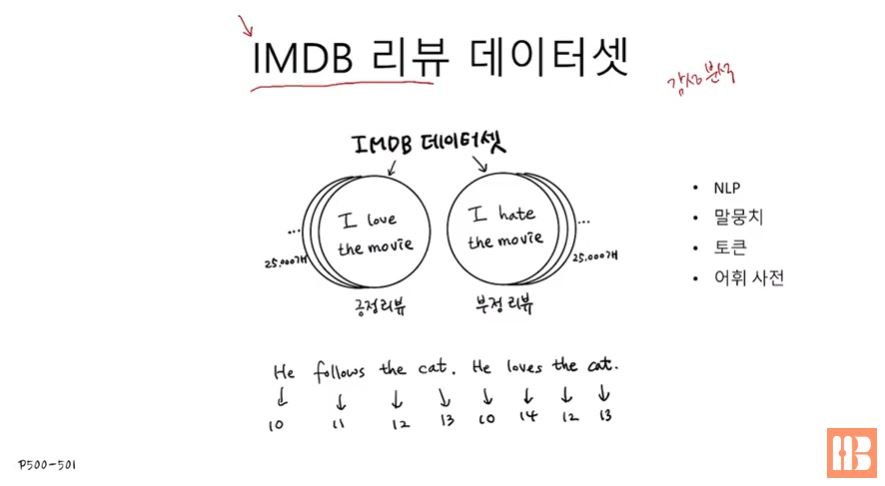

- IMDB 리뷰: 영화 평점 리뷰 데이터셋!
- 감정 분석에 해당
- **자연어 처리**에 해당 (NLP)
- **말뭉치** (NLP에서 데이터셋과 같은 말)
- **토큰** (공백을 기준으로 분리한 각각의 데이터)
- **어휘 사전** (중복을 제외한 말뭉치의 단어들)

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## IMDB 리뷰 데이터셋

In [ ]:
# keras의 imdb 클래스로 데이터를 불러올 수 있음
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
# 각각 25000개 (긍정과 부정)
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [ ]:
print(len(train_input[0]))

218


In [ ]:
print(len(train_input[1]))

189


In [ ]:
# 1: 첫 번째 토큰
# 2: 어휘 사전에 없는 토큰
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [ ]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [ ]:
from sklearn.model_selection import train_test_split

# 훈련 셋 준비
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [ ]:
import numpy as np

lengths = np.array([len(x) for x in train_input])

In [ ]:
# 문장의 길이 평균, 중간값
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


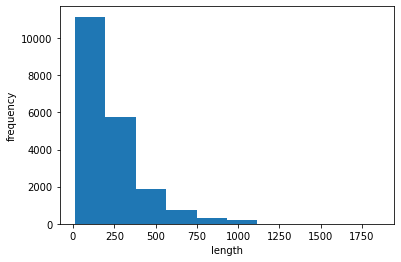

In [ ]:
import matplotlib.pyplot as plt

# 문장의 길이와 등장 횟수
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

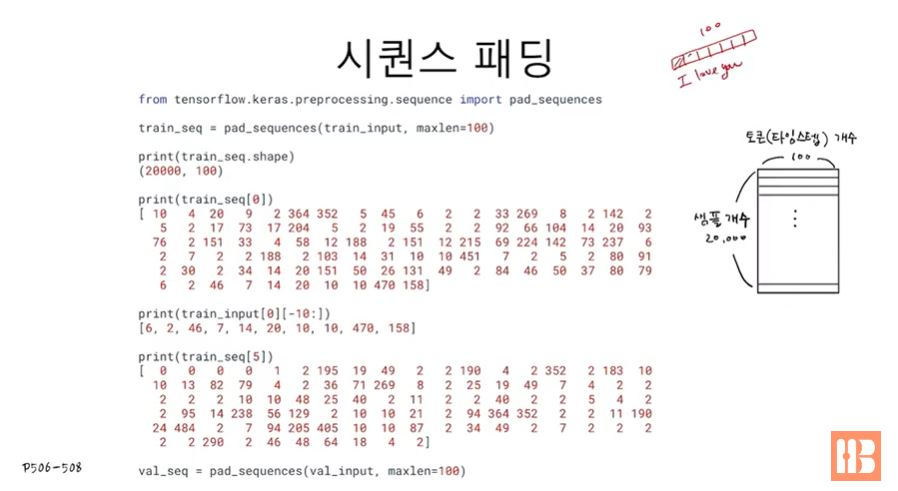

- train_input의 길이를 정하고 그 길이보다 작은 문자열의 경우에는 빈 토큰을 패딩으로 사용하는 방식

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 100개의 토큰만 사용하도록 제한 (남은 빈 토큰은 패딩으로 사용)
train_seq = pad_sequences(train_input, maxlen=100)

In [ ]:
print(train_seq.shape)

(20000, 100)


In [ ]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [ ]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [ ]:
# 앞 부분이 패딩되어 있음 - 뒷부분에 의미있는 데이터가 오도록
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [ ]:
val_seq = pad_sequences(val_input, maxlen=100)

## 순환 신경망 만들기

In [ ]:
from tensorflow import keras

model = keras.Sequential()

# 순환신경망 = SimpleRNN
# 뉴런의 개수 = 8
# 토큰의 개수 = 100
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

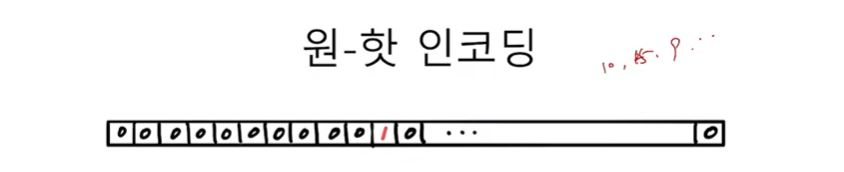

## 원-핫 인코딩
- 해당 단어의 위치만 1로 두고 나머지는 모두 0으로 두는 방식
- 정수로 이루어진 값을 0과 1의 불리언 값으로 변환해 단순화하고자 함

In [ ]:
# to_categorical: 자동으로 최대값과 최소값을 찾아 변환
# 500개의 단어 개수만큼 원-핫 인코딩 진행
train_oh = keras.utils.to_categorical(train_seq)

In [ ]:
print(train_oh.shape)

(20000, 100, 500)


In [ ]:
# 첫 번째 토큰을 출력했을 때
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
print(np.sum(train_oh[0][0]))

1.0


In [ ]:
val_oh = keras.utils.to_categorical(val_seq)

In [ ]:
# 모델 구조 확인
# simple_rnn Params = 500 * 8 + 8 * 8 + 8(절편)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


## 순한 신경망 훈련하기

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 24s 73ms/step - loss: 0.6989 - accuracy: 0.5041 - val_loss: 0.6978 - val_accuracy: 0.5038
Epoch 2/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6946 - accuracy: 0.5102 - val_loss: 0.6949 - val_accuracy: 0.5102
Epoch 3/100
313/313 [==============================] - 17s 53ms/step - loss: 0.6920 - accuracy: 0.5200 - val_loss: 0.6930 - val_accuracy: 0.5146
Epoch 4/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6901 - accuracy: 0.5302 - val_loss: 0.6916 - val_accuracy: 0.5230
Epoch 5/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6883 - accuracy: 0.5408 - val_loss: 0.6905 - val_accuracy: 0.5270
Epoch 6/100
313/313 [==============================] - 17s 55ms/step - loss: 0.6866 - accuracy: 0.5472 - val_loss: 0.6894 - val_accuracy: 0.5356
Epoch 7/100
313/313 [==============================] - 17s 55ms/step - loss: 0.6845 - accuracy: 0.5563 - val_loss: 0.6880 - val_ac

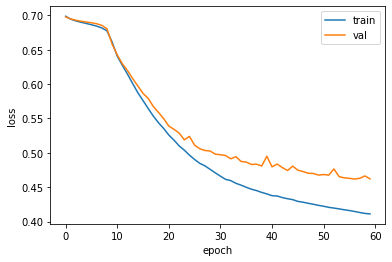

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# 80%의 정확도!

## 단어 임베딩을 사용하기

- 20000개의 샘플 * 100개의 토큰 * 500개의 원핫인코딩
- 어휘사전을 늘릴 수록 용량이 부담스러워짐

## 임베딩
- 토큰을 실수 벡터로 변환하는 방식
- 원핫인코딩의 단점을 보완
- 단어 사이의 거리를 계산해 유사성을 더 쉽게 판단할 수 있음

In [ ]:
model2 = keras.Sequential()

# 500개의 어휘 사전
# 하나의 토큰을 16개의 벡터로 변환
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

# embedding Params: 500 * 16 = 8000
# simple_rnn_1: 16 * 8 + 8 * 8 + 8 = 200
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best_embedding-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 21ms/step - loss: 0.6949 - accuracy: 0.5066 - val_loss: 0.6933 - val_accuracy: 0.5052
Epoch 2/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6914 - accuracy: 0.5254 - val_loss: 0.6914 - val_accuracy: 0.5242
Epoch 3/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6888 - accuracy: 0.5439 - val_loss: 0.6877 - val_accuracy: 0.5494
Epoch 4/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6793 - accuracy: 0.6054 - val_loss: 0.6740 - val_accuracy: 0.6294
Epoch 5/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6614 - accuracy: 0.6690 - val_loss: 0.6552 - val_accuracy: 0.6844
Epoch 6/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6403 - accuracy: 0.7056 - val_loss: 0.6359 - val_accuracy: 0.7028
Epoch 7/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6205 - accuracy: 0.7247 - val_loss: 0.6177 - val_accuracy:

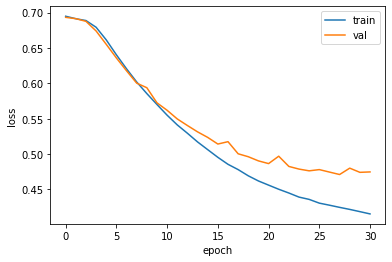

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()